<a href="https://colab.research.google.com/github/packtpublishing/Machine-Learning-for-Imbalanced-Data/blob/main/chapter08/Tweet_emotion_detection_using_class_weights_Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference https://github.com/trhgquan/MTH089/blob/dae5a8f8f7707aa9cac1df9f7b0011d4f7a741d7/practice/TREC-classification/code/deep-learning/BERT-based-classification.ipynb


In [1]:
!pip install transformers==4.25.1 datasets==2.8.0 accelerate==0.15.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.6 MB/s eta 0:00:00


In [2]:
import os
import re
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing

from transformers import AutoTokenizer
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import torch
from torch.utils.checkpoint import checkpoint
import torch.nn as nn

os.environ["TOKENIZERS_PARALLELISM"] = "true"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

torch.manual_seed(42)
random.seed(0)
np.random.seed(84)

In [3]:
model_name = "distilbert-base-uncased"

## Prepare Data

### Get Data - And apply simple normalization

In [4]:
from datasets import load_dataset

train_dataset = load_dataset("trec", split="train")
test_dataset = load_dataset("trec", split="test")

Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset trec downloaded and prepared to /root/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2. Subsequent calls will reuse this data.


# Let's make this imbalanced by removing a bunch of examples from class 0 and class 2

In [5]:
# filter() returns rows that match a specified condition: if probability > .8 and label is 0 or 2, then take it.
train_dataset = train_dataset.filter(
    lambda x: random.random() > 0.8 if (x["coarse_label"] in (0, 2)) else True
)

  0%|          | 0/6 [00:00<?, ?ba/s]

In [6]:
print(train_dataset.features["coarse_label"].names)
print(train_dataset.features["coarse_label"])

['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM']
ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None)


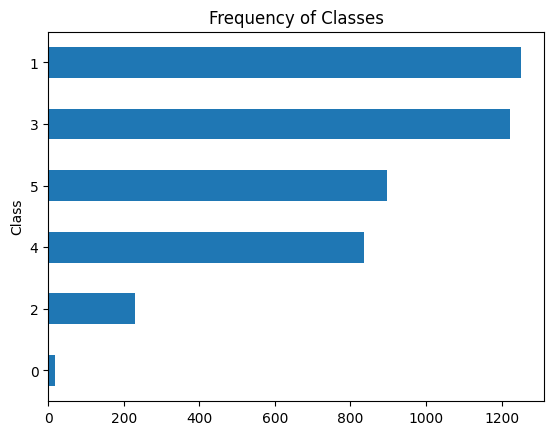

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

pd.Series(train_dataset["coarse_label"]).value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.ylabel("Class")
plt.show()

# Print frequency of various classes: verify class imbalance

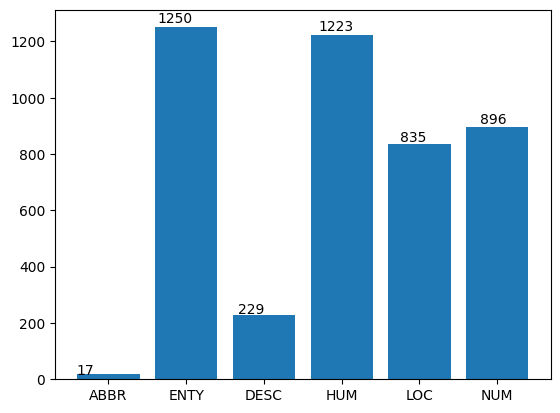

In [8]:
fig, ax = plt.subplots()
_, counts = np.unique(train_dataset["coarse_label"], return_counts=True)
ax.bar(train_dataset.features["coarse_label"].names, counts)
ax.set_xticks(train_dataset.features["coarse_label"].names)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.04, p.get_height() * 1.012))
plt.show()

In [9]:
train, dev = train_dataset.train_test_split(
    test_size=0.2, seed=42, stratify_by_column="coarse_label"
).values()

In [10]:
test_dataset

Dataset({
    features: ['text', 'coarse_label', 'fine_label'],
    num_rows: 500
})

In [11]:
print(train.features["coarse_label"])
label_names = train.features["coarse_label"].names
print(label_names)

ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None)
['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM']


In [12]:
from datasets import DatasetDict

dataset = DatasetDict({"train": train, "dev": dev, "test": test_dataset})

In [13]:
# Get tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 512

In [14]:
tokenizer(dataset["train"][0]["text"])

{'input_ids': [101, 2129, 2515, 1037, 4045, 10250, 19879, 4263, 2147, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [15]:
from collections import Counter

Counter(test_dataset["coarse_label"])

Counter({5: 113, 4: 81, 3: 65, 2: 138, 1: 94, 0: 9})

## Create tokenized dataset

In [16]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)


tokenized_dataset = dataset.map(
    preprocess_function, batched=True, remove_columns=["fine_label"]
)
tokenized_dataset = tokenized_dataset.rename_column("coarse_label", "labels")
tokenized_dataset

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 3560
    })
    dev: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 890
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 500
    })
})

In [17]:
from collections import Counter

print(Counter(tokenized_dataset["train"]["labels"]))
print(Counter(tokenized_dataset["dev"]["labels"]))
print(Counter(tokenized_dataset["test"]["labels"]))

Counter({1: 1000, 3: 978, 5: 717, 4: 668, 2: 183, 0: 14})
Counter({1: 250, 3: 245, 5: 179, 4: 167, 2: 46, 0: 3})
Counter({2: 138, 5: 113, 1: 94, 4: 81, 3: 65, 0: 9})


### Create a label column and input column
* Input is going to be [discourse_text + essay_text]
* Label is going to be numericalised version of the three classes

## Define Dynamic padding

In [18]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Define model

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

## Define Training Arguments

In [20]:
def trainaug(runname):
    training_args = TrainingArguments(
        run_name=runname,
        output_dir="./results",
        num_train_epochs=5,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        auto_find_batch_size=True,
        gradient_accumulation_steps=4,
        fp16=True,  # uncomment if training on GPU
        log_level="error",
    )
    return training_args


training_args = trainaug(model_name)

In [21]:
from transformers import EvalPrediction
from typing import Dict
from sklearn.metrics import precision_score, recall_score, f1_score


def custom_compute_metrics(res: EvalPrediction) -> Dict:
    pred = res.predictions.argmax(axis=1)
    target = res.label_ids
    precision = precision_score(target, pred, average="macro")
    recall = recall_score(target, pred, average="macro")
    f1 = f1_score(target, pred, average="macro")
    return {"precision": precision, "recall": recall, "f1": f1}


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # print(inputs)
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

## Define Trainer

In [22]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=custom_compute_metrics,
)

## Train the model

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
0,No log,0.300792,0.741441,0.691397,0.703288
1,No log,0.244023,0.767893,0.755640,0.760697
2,No log,0.217956,0.951520,0.808275,0.848400
3,No log,0.205771,0.946781,0.828028,0.859289
4,0.277800,0.210412,0.945396,0.824418,0.856655


TrainOutput(global_step=555, training_loss=0.2520319065532169, metrics={'train_runtime': 102.9475, 'train_samples_per_second': 172.904, 'train_steps_per_second': 5.391, 'total_flos': 97587828203040.0, 'train_loss': 0.2520319065532169, 'epoch': 5.0})

Our best F1-score is 0.766 at 6th epoch.

In [24]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=1)

In [25]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.94      0.87      0.90       101
           2       0.91      0.95      0.93       132
           3       0.97      0.97      0.97        65
           4       0.99      0.99      0.99        81
           5       0.99      0.97      0.98       115

    accuracy                           0.95       500
   macro avg       0.91      0.96      0.93       500
weighted avg       0.95      0.95      0.95       500



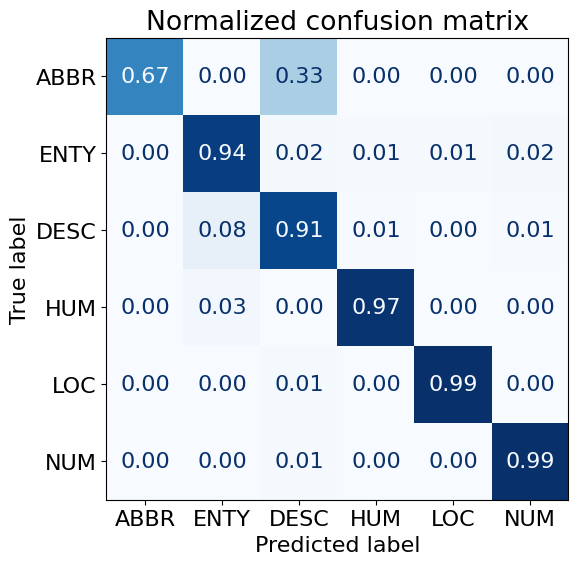

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 16})


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

    plt.title("Normalized confusion matrix")

    plt.show()


plot_confusion_matrix(predictions, labels, label_names)

# Let's get the class weights for the dataset using sklearn's `compute_class_weight` API

In [27]:
# use the class_weights obtained using sklearn's compute_class_weight function
from sklearn.utils import class_weight
from collections import Counter

y = dataset["train"]["coarse_label"]
class_weights = class_weight.compute_class_weight(
    "balanced", classes=np.unique(y), y=np.asarray(y)
)
class_weights

array([42.38095238,  0.59333333,  3.24225865,  0.6066803 ,  0.88822355,
        0.82752208])

In [28]:
class CustomTrainerWeighted(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(
            weight=torch.from_numpy(class_weights).cuda(0).float()
        )  # using gpu
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [29]:
modelWeighted = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=6
)

trainerWeighted = CustomTrainerWeighted(
    model=modelWeighted,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=custom_compute_metrics,
)

In [30]:
trainerWeighted.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
0,No log,0.379123,0.749285,0.743340,0.745025
1,No log,0.320126,0.948300,0.823101,0.856919
2,No log,0.282939,0.946484,0.840759,0.865725
3,No log,0.302956,0.869508,0.837595,0.850697
4,0.317800,0.297158,0.950919,0.839207,0.867263


TrainOutput(global_step=555, training_loss=0.2895190213177655, metrics={'train_runtime': 95.9037, 'train_samples_per_second': 185.603, 'train_steps_per_second': 5.787, 'total_flos': 97587828203040.0, 'train_loss': 0.2895190213177655, 'epoch': 5.0})

Our best F1-score is 0.773 at 7th epoch, which is a bit more than the score(=0.769) obtained without class weighting.

In [31]:
predictions, labels, _ = trainerWeighted.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=1)
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88         7
           1       0.93      0.94      0.93        93
           2       0.96      0.95      0.96       140
           3       0.98      0.98      0.98        65
           4       0.99      0.98      0.98        82
           5       0.98      0.98      0.98       113

    accuracy                           0.96       500
   macro avg       0.94      0.97      0.95       500
weighted avg       0.96      0.96      0.96       500



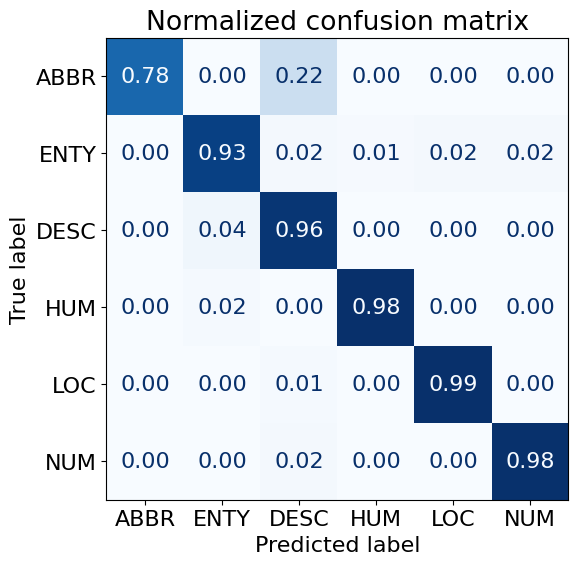

In [32]:
plot_confusion_matrix(predictions, labels, label_names)